<a href="https://colab.research.google.com/github/JS0501/ESAA_OB/blob/main/ESAA1128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **7.5 LSTM**

RNN은 가중치가 업데이트되는 과정에서 기울기가 1보다 작은 값이 계속 곱해지기 때문에 기울기가 사라지는 기울기 소멸 문제가 발생한다.

이를 해결하기 위해 LSTM이나 GRU 같은 확장된 RNN 방식들을 사용한다.

#### **7.5.1 LSTM 구조**

##### **LSTM 순전파**

LSTM은 기울기 소멸 문제를 해결하기 위해 망각 게이트, 입력 게이트, 출력 게이트라는 새로운 요소를 은닉층의 각 뉴런에 추가했다.

1) **망각 게이트**

망각 게이트는 과거 정보를 어느 정도 기억할지 결정한다.

과거 정보와 현재 데이터를 입력받아 시그모이드를 취한 후 그 값을 과거 정보에 곱한다.

따라서 시그모이드의 출력이 0이면 과거 정보는 버리고, 1이면 과거 정보는 온전히 보존한다.

2) **입력 게이트**

입력 게이트는 현재 정보를 기억하기 위해 만들어졌다.

과거 정보와 현재 데이터를 입력받아 시그모이드와 하이퍼볼릭 탄젠트 함수를 기반으로 현재 정보에 대한 보존량을 결정한다.

즉, 현재 메모리에 새로운 정보를 반영할지 결정하는 역할을 한다.

3) **셀**

각 단계에 대한 은닉 노드를 메모리 셀이라고 한다.

'총합(sum)'을 사용하여 셀 값을 반영하며, 이것으로 기울기 소멸 문제가 해결된다.

망각 게이트와 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태를 업데이트한다.

4) **출력 게이트**

출력 게이트는 과거 정보와 현재 데이터를 사용하여 뉴런의 출력을 결정한다

이전 은닉 상태와 t번째 입력을 고려해서 다음 은닉 상태를 계산한다.

그리고 LSTM에서는 이 은닉 상태가 그 시점에서의 출력이 된다.

출력 게이트는 갱신된 메모리의 출력 값을 제어하는 역할을 한다.

- 계산한 값이 1이면 의미 있는 결과로 최종 출력

- 계산한 값이 0이면 해당 연산을 출력하지 않음

##### **LSTM 역전파**

LSTM은 셀을 통해서 역전파를 수행하기 때문에 '중단 없는 기울기'라고도 한다.

즉, 최종 오차는 모든 노드에 전파되는데, 이때 셀을 통해서 중단 없이 전파된다.

이때 셀 단위로 오차가 전파된다고 해서, 입력 방향으로 오차가 전파되지 않는 것은 아니다.

셀 내부적으로는 오차가 입력으로 전파된다는 것을 잊지 말아야 한다.

In [ ]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter # 파라미터 목록을 갖고 있는 라이브러리
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

In [ ]:
# 데이터 전처리
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
]) # 데이터 정규화(평균 0.5, 표준편차 1.0)

In [ ]:
# 데이터셋 내려받기
from torchvision.datasets import MNIST

download_root = './data'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.2MB/s]


In [ ]:
# 데이터셋 메모리로 가져오기
# 각 개체가 호출될 때 메모리로 불러온다는 점.
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
# 변수에 대한 값 지정
batch_size=100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [ ]:
# LSTM 셀 네트워크 구축 (셀에 집중한 네트워크)
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self) : # 모델 파라미터 초기화
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std) # 난수생성

    def forward(self, x, hidden) :
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx) # 모든 게이트를 구하는 코드
        gates = gates.squeeze() # 텐서 차원 감소
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 적용
        forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 적용
        cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 적용
        outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 적용

        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate) # 텐서 곱셈
        hy = torch.mul(outgate, F.tanh(cy))

        return (hy, cy)

In [ ]:
# LSTM 셀의 전반적인 네트워크 구축
class LSTMModel(nn.Module) :
   def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim # 은닉층 뉴런, 유닛 개수

       self.layer_dim = layer_dim
       self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim) # 앞에서 정의한 함수 불러오기
       self.fc = nn.Linear(hidden_dim, output_dim)

   def forward(self, x) :
       if torch.cuda.is_available() :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

       if torch.cuda.is_available() :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

       outs = []
       cn =  c0[0,:,:]
       hn = h0[0,:,:]

       for seq in range(x.size(1)) : #LSTM 겔 계층 반복해 쌓음
           hn, cn = self.lstm(x[:, seq, :], (hn, cn))
           outs.append(hn)

       out = outs[-1].squeeze()
       out = self.fc(out)
       return out

In [ ]:
# 옵티마이저, 손실 함수 지정
input_dim=28
hidden_dim=128
layer_dim=1
output_dim=18

model =  LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available() :
   model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate =0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습 및 성능 확인
seq_dim=28
loss_list = []
iter = 0
for epoch in range(num_epochs) :
   for i, (images ,labels) in enumerate(train_loader) :
       if torch.cuda.is_available() :
           images = Variable(images.view(-1, seq_dim, input_dim).cuda())
           labels = Variable(labels.cuda())

       else :
           images = Variable(images.view(-1, seq_dim, input_dim))
           labels = Variable(labels)

       optimizer.zero_grad()
       outputs = model(images)
       loss = criterion(outputs, labels)

       if torch.cuda.is_available() :
           loss.cuda()

       loss.backward()
       optimizer.step()
       loss_list.append(loss.item())
       iter += 1


       if iter % 500 == 0 :
           correct = 0
           total = 0

           for images, labels in valid_loader :

               if torch.cuda.is_available() :
                   images = Variable(images.view(-1, seq_dim, input_dim).cuda())
               else :
                   images = Variable(images.view(-1, seq_dim, input_dim))

               outputs = model(images)
               _, predicted = torch.max(outputs.data, 1)

               total += labels.size(0)
               if torch.cuda.is_available() :
                   correct += (predicted.cpu() == labels.cpu()).sum()

               else :
                   correct += (predicted == labels).sum()

           accuracy = 100 * correct / total
           print(f'Iteration : {iter} Loss : {loss.item()} Accuracy : {accuracy}')

Iteration : 500 Loss : 2.1343955993652344 Accuracy : 28.09000015258789
Iteration : 1000 Loss : 0.760982096195221 Accuracy : 78.83999633789062
Iteration : 1500 Loss : 0.3086998462677002 Accuracy : 90.7300033569336
Iteration : 2000 Loss : 0.09612472355365753 Accuracy : 93.55999755859375
Iteration : 2500 Loss : 0.06641891598701477 Accuracy : 95.20999908447266
Iteration : 3000 Loss : 0.06276841461658478 Accuracy : 96.19000244140625
Iteration : 3500 Loss : 0.123725026845932 Accuracy : 95.26000213623047
Iteration : 4000 Loss : 0.13091576099395752 Accuracy : 97.04000091552734
Iteration : 4500 Loss : 0.10493671149015427 Accuracy : 97.25
Iteration : 5000 Loss : 0.06193014234304428 Accuracy : 97.31999969482422
Iteration : 5500 Loss : 0.008130054920911789 Accuracy : 97.62000274658203
Iteration : 6000 Loss : 0.11186946928501129 Accuracy : 97.43000030517578
Iteration : 6500 Loss : 0.029249951243400574 Accuracy : 97.52999877929688
Iteration : 7000 Loss : 0.06277099996805191 Accuracy : 97.98000335693

In [ ]:
# 테스트 데이터셋으로 성능 확인
def evaluate(model, val_iter) :
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter :
        if torch.cuda.is_available() :
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = labels.cuda()
        else :
            images = Variable(images.view(-1, seq_dim, input_dim).to(device))
            labels = labels.to(device)

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction='sum') # 모든 오차 총합
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [ ]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model, test_loader)
print("Test Loss : %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss :  0.06 | Test Accuracy:  0.98




---



In [ ]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
!git clone https://github.com/gilbutITbook/080289.git

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 26.04 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.


In [ ]:
data=pd.read_csv("/content/080289/chap07/data/SBUX.csv")
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
# 날짜 칼럼 인덱스 처리
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
data['Volume']=data['Volume'].astype(float)

In [ ]:
# 훈련, 레이블 분리
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [ ]:
# 데이터 분포 조정
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape" , X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


* 데이터셋 그자체가 아닌, 네트워크에서 정의된 형태, 크기에 따라 조정 후 네트워크로 보내야함

In [ ]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [ ]:
# LSTM 네트워크 구축
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers # LSTM 계층 개수
        self.input_size = input_size # 입력 크기
        self.hidden_size = hidden_size # 은닉층 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.fc = nn.Linear(128, num_classes) # 출력층
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉상태 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉, 셀 상태 적용
        hn = hn.view(-1, self.hidden_size) # 데이터 형태 조정
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
# 변수 값 설정
num_epochs = 1000
lr = 0.0001

input_size=5
hidden_size=2
num_layers=1

num_classes=1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0 :
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.14250
Epoch: 100, loss: 0.01529
Epoch: 200, loss: 0.01107
Epoch: 300, loss: 0.01075
Epoch: 400, loss: 0.01077
Epoch: 500, loss: 0.01070
Epoch: 600, loss: 0.01086
Epoch: 700, loss: 0.01066
Epoch: 800, loss: 0.01080
Epoch: 900, loss: 0.01193


In [ ]:
# 예측 결과 출력을 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

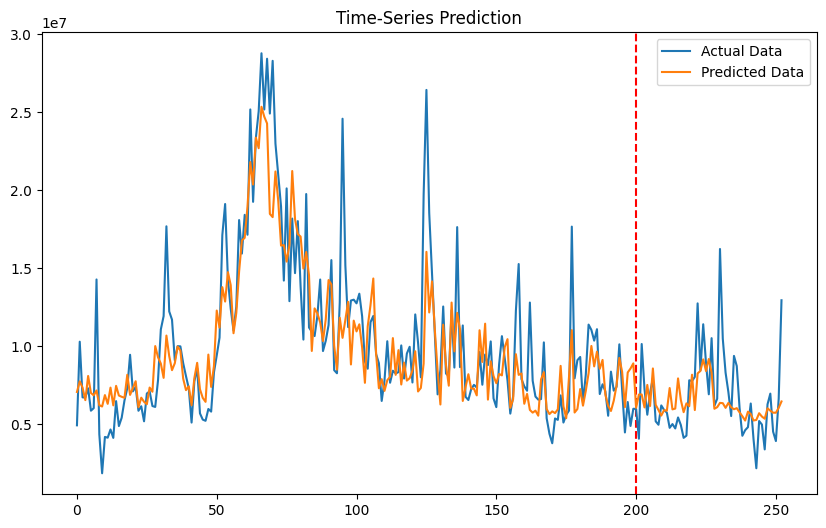

In [ ]:
# 예측 결과 출력, 그래프로 시각화
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()